<a href="https://colab.research.google.com/github/Melsonwang1/CVNL-assignment/blob/main/RNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cd /content/drive/My\ Drive/Colab\ Notebooks
!ls

drive  sample_data


In [3]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from dlmam import *
from sklearn.metrics import accuracy_score
import unicodedata
import string

/content/drive/My Drive/Colab Notebooks/dlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [10]:
from datasets import load_dataset

# Load the SNIPS dataset
dataset = load_dataset("snips_built_in_intents")

# View the dataset structure
print(dataset)

# Inspect the first few training examples
print(dataset["train"][:5])

label_mapping = dataset["train"].features["label"].names
print(label_mapping)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 328
    })
})
{'text': ["Share my location with Hillary's sister", 'Send my current location to my father', 'Share my current location with Jim', 'Send my location to my husband', 'Send my location'], 'label': [5, 5, 5, 5, 5]}
['ComparePlaces', 'RequestRide', 'GetWeather', 'SearchPlace', 'GetPlaceDetails', 'ShareCurrentLocation', 'GetTrafficInformation', 'BookRestaurant', 'GetDirections', 'ShareETA']


In [12]:
intent_classification_data = {}

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
  alphabet[all_letters[i]] = i

def unicodeToAscii(s):
#Turns a Unicode string into plain ASCII
  return ''.join(
    c for c in unicodedata.normalize('NFD', s)
    if unicodedata.category(c) != 'Mn'
    and c in all_letters
)

for sample in dataset["train"]:
  text = sample["text"] # The text sample
  label = sample["label"]  # The list of labels for this sample

  # Normalize the text using the unicodeToAscii function
  normalized_text = unicodeToAscii(text).lower()

  intent = label_mapping[label]  # Map label index to intent name

  # Add to the emotion_data dictionary
  if intent not in intent_classification_data:
      intent_classification_data[intent] = []  # Initialize the list for this intent
  intent_classification_data[intent].append(normalized_text)

# Print out the intent names and their respective text count
for intent, texts in intent_classification_data.items():
    print(f"{intent}: {len(texts)} samples")

ShareCurrentLocation: 16 samples
ComparePlaces: 19 samples
GetPlaceDetails: 50 samples
SearchPlace: 28 samples
BookRestaurant: 70 samples
RequestRide: 26 samples
GetDirections: 35 samples
ShareETA: 22 samples
GetTrafficInformation: 20 samples
GetWeather: 42 samples


In [13]:
class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary):
      self.label_names = [x for x in lang_name_dict.keys()]
      self.data = []
      self.labels = []
      self.vocabulary = vocabulary
      for y, language in enumerate(self.label_names):
          for sample in lang_name_dict[language]:
              if len(sample) > 0:  # Filter out empty inputs
                  self.data.append(sample)
                  self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long
        values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """

        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Convert the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label

In [14]:
dataset = LanguageNameDataset(intent_classification_data, alphabet)

# Limit the dataset size to 20,000 samples
total_size = min(len(dataset), 20000)  # Use the smaller of the dataset size or 20,000

# Define proportions
train_ratio = 0.8  # 80% training
test_ratio = 0.2   # 20% testing

# Compute split sizes
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Take a subset of the dataset if the dataset is larger than 20,000
subset_indices = torch.randperm(len(dataset))[:total_size]  # Randomly select 20,000 indices
subset_dataset = torch.utils.data.Subset(dataset, subset_indices)

# Randomly split the subset dataset
train_data, test_data = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [15]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)

    print(input_sequence.shape, x_seq.shape)
    print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[1.0354, 1.0689],
        [1.0420, 0.4640],
        [1.0420, 0.4640],
        [1.0354, 1.0689],
        [0.9483, 0.8281]])


In [16]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple,
            last_step = last_step[0]#then h_t is the first item in the tuple

        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1]
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)

        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)

In [17]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  #the tanh activation is built into the RNN object, so we don't need to do it here
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

In [18]:
for batch in train_loader:
    input_data, labels = batch
    print(input_data.shape)
    break

torch.Size([1, 32])


In [19]:
for idx, data in enumerate(train_data):
    input_vec, label = data
    if len(input_vec) == 0:
        print(f"Empty input found at index {idx}")

In [20]:
loss_func = nn.CrossEntropyLoss()
device = "cuda"
batch_one_train = train_simple_network(first_rnn, \
              loss_func, train_loader, \
              test_loader=test_loader, \
              score_funcs={'Accuracy': accuracy_score},\
              device=device, epochs=20)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

Training:   0%|          | 0/262 [00:00<?, ?it/s]

Testing:   0%|          | 0/66 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

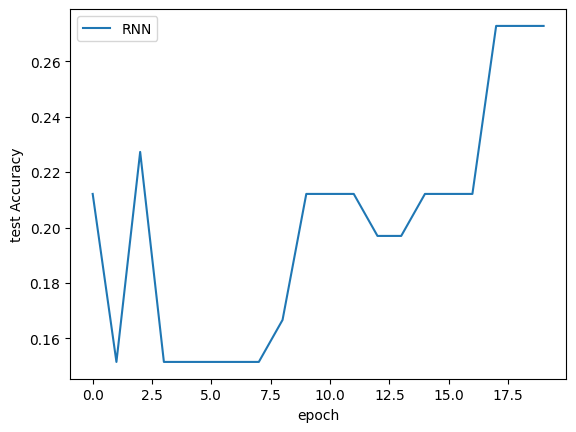

In [21]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_one_train, label='RNN')